# [Variational Auto-Encoder](https://wikidocs.net/152474)
- VAE는 Input image X를 잘 설명하는 feature를 추출하여 Latent vector z에 담고, 이 Latent vector z를 통해 X와 유사하지만 완전히 새로운 데이터를 생성하는 것을 목표로 합니다.
- 이때 각 feature가 가우시안 분포를 따른다고 가정하고 latent z는각 feature의 평균과 분산값을 나타냅니다.

예를 들어 한국인의 얼굴을 그리기 위해 눈, 코, 입 등의 feature를 Latent vector z에 담고, 그 z를 이용해 그럴듯한 한국인의 얼굴을 그려내는 것입니다. latent vector z는 한국인 눈 모양의 평균 및 분산, 한국인 코 길이의 평균 및 분산, 한국인 머리카락 길이의 평균 및 분산 등등의 정보를 담고 있다고 생각할 수 있겠습니다.

## VAE 모델 구조

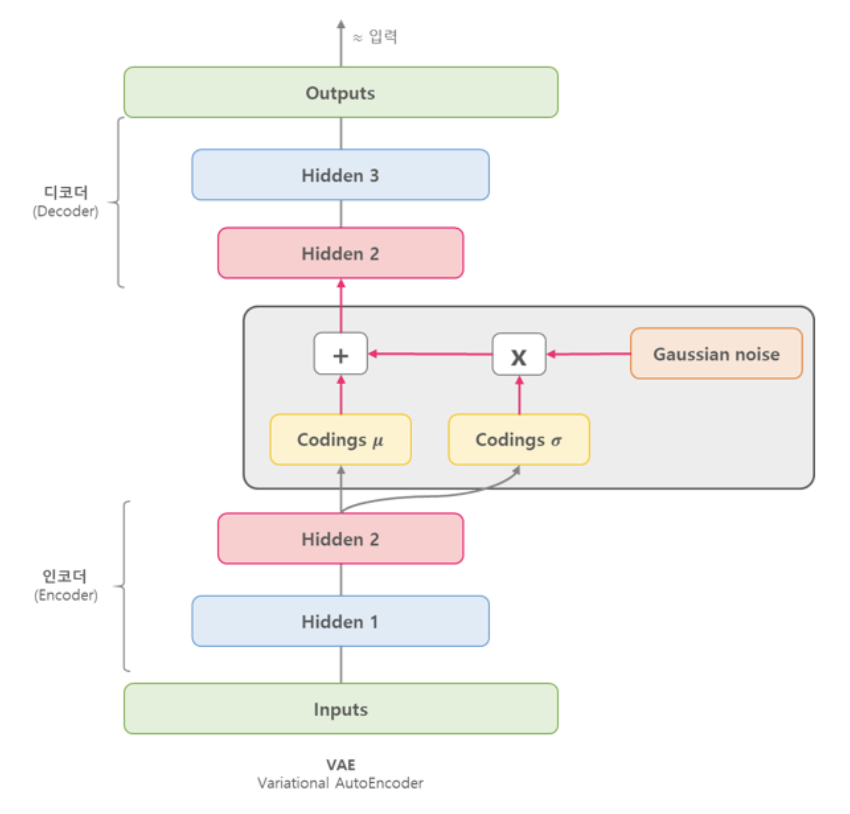

- Input image X를 Encoder에 통과시켜 Latent vector z를 구하고, Latent vector z를 다시 Decoder에 통과시켜 기존 input image X와 비슷하지만 새로운 이미지 X를 찾아내는 구조입니다.
- VAE는 input image가 들어오면 그 이미지에서의 다양한 특징들이 각각의 확률 변수가 되는 어떤 확률 분포를 만들게 됩니다. 이런 확률 분포를 잘 찾아내고, 확률값이 높은 부분을 이용하면 실제에 있을법한 이미지를 새롭게 만들 수 있을 것입니다.

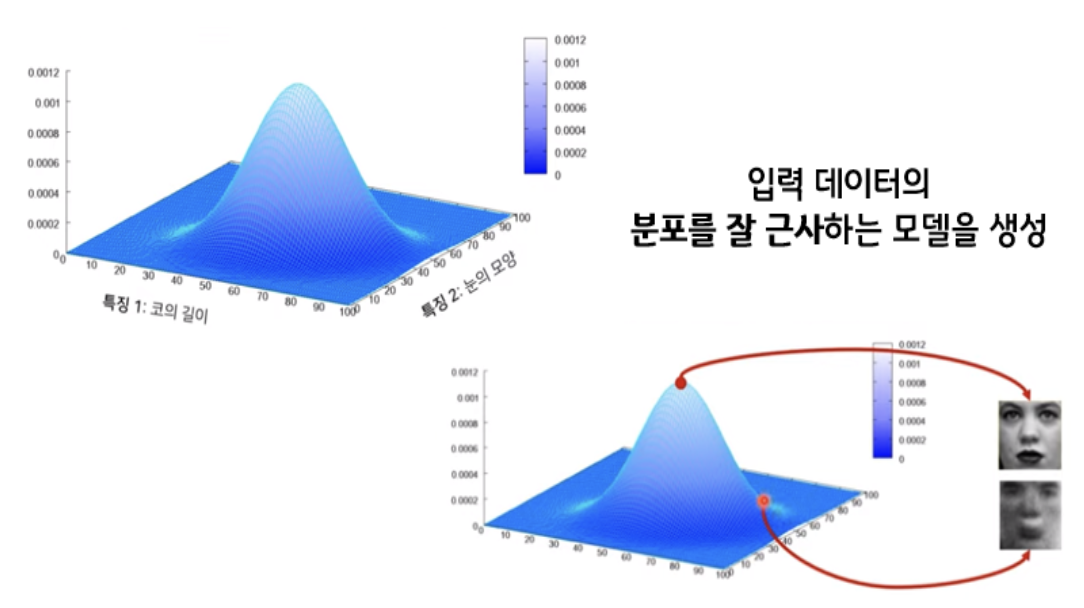

## AE vs. VAE
- VAE(Variational AutoEncoder)는 기존의 AutoEncoder와 탄생 배경이 다르지만 구조가 상당히 비슷해서 Variational AE라는 이름이 붙은 것입니다.
- 즉, VAE와 AE는 엄연히 다릅니다.

### 모델 구조 비교

AutoEncoder의 목적은 Encoder에 있습니다. AE는 Encoder 학습을 위해 Decoder를 붙인 것입니다.

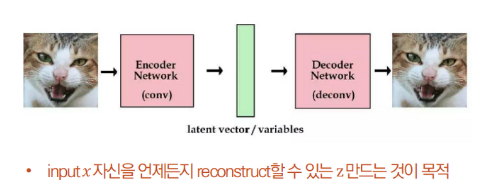

반대로 VAE의 목적은 Decoder에 있습니다. Decoder 학습을 위해 Encoder를 붙인 것입니다.

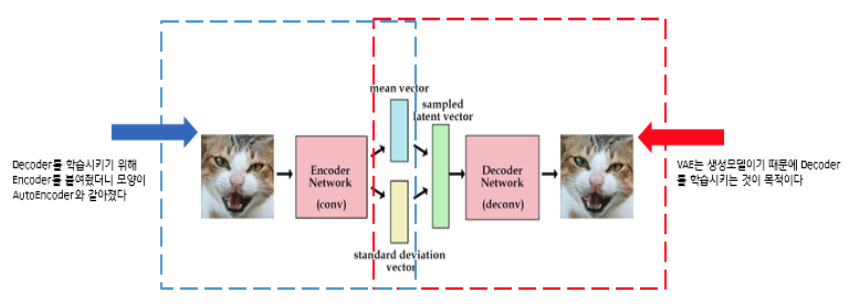

### 학습 방법 비교

VAE는 단순히 입력값을 재구성하는 AE에서 발전한 구조로 추출된 잠재 코드의 값을 하나의 숫자로 나타내는 것이 아니라, 가우시안 확률 분포에 기반한 확률값 으로 나타낸다.

- AE : 잠재 코드 값이 어떤 하나의 값
- VAE : 잠재 코드 값이 평균과 분산으로 표현되는 어떤 가우시안 분포

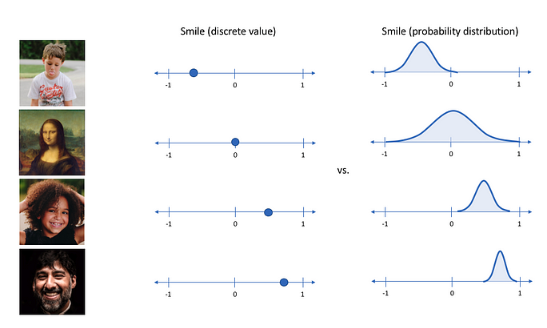

### 결론

- 아래 그림은 MNist 데이터를 각각 AE와 VAE로 특징을 추출해 표현한 그림이다. 각 점의 색깔은 MNIST 데이터인 0~9의 숫자를 나타낸다.
- AE가 만들어낸 잠재 공간은 군집이 비교적 넓게 퍼져있고, 중심으로 잘 뭉쳐있지 않지만, VAE가 만들어낸 잠재 공간은 중심으로 더 잘 뭉쳐져 있는 것을 확인 할 수 있다.

따라서 원본 데이터를 재생하는데 AE에 비해서 VAE가 더 좋은 성능을 보인다는 것을 알 수 있다. 즉 VAE를 통해서 데이터의 특징을 파악하는게 더 유리하다.

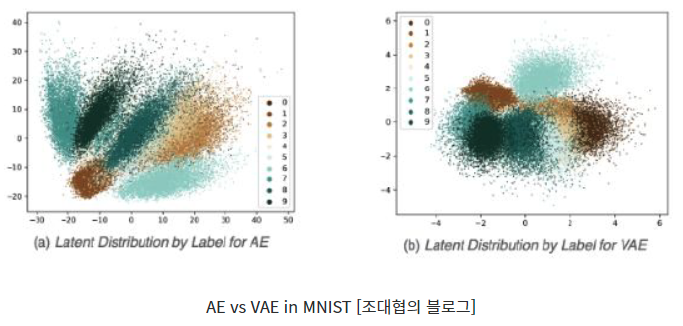

# Global Variables

In [ ]:
import easydict
args = easydict.EasyDict()

args.NUM_EPOCHS = 100
args.NUM_TRIALS = 5

args.best_vae_model = 'best_vae_model.pt'
args.best_cvae_model = 'best_cvae_model.pt'

args.predict_img_vae = 'predict_img_vae.png'
args.predict_img_cvae = 'predict_img_cvae.png'

# Data

In [ ]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1+cu118'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo

In [ ]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )


## Dataset

In [ ]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)


## DataLoader

In [ ]:
bs = 100

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


# [VAE](https://github.com/lyeoni/pytorch-mnist-VAE/tree/master)

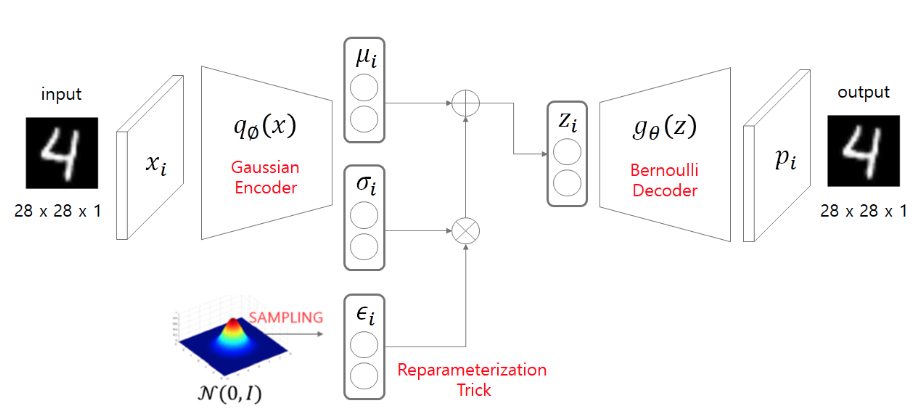

## Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()

        # decoder part
        self.fc1 = nn.Linear(z_dim, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc3 = nn.Linear(h_dim1, x_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return F.sigmoid(self.fc3(h))

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim=784, h_dim1=512, h_dim2=256, z_dim=2):
        super().__init__()
        self.x_dim = x_dim

        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        # decoder part
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


In [ ]:
reset_seeds()

# build model
vae_model = VAE().to(device)
vae_model

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc31): Linear(in_features=256, out_features=2, bias=True)
    (fc32): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
torchinfo.summary(vae_model,(32, 1, 28, 28), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
VAE                                      --                        [32, 1, 28, 28]           [32, 784]                 --
├─Encoder: 1-1                           --                        [32, 784]                 [32, 2]                   --
│    └─Linear: 2-1                       --                        [32, 784]                 [32, 512]                 401,920
│    └─Linear: 2-2                       --                        [32, 512]                 [32, 256]                 131,328
│    └─Linear: 2-3                       --                        [32, 256]                 [32, 2]                   514
│    └─Linear: 2-4                       --                        [32, 256]                 [32, 2]                   514
├─Decoder: 1-2                           --                        [32, 2]                   [32, 784]                 --
│    └─

## Engine

In [ ]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss: # 현재 loss가 최고 loss보다 더 낮은 경우
            self.best_loss = loss # 최고 loss를 현재 loss로 업데이트
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path) # 최고 loss를 갖은 모델 저장
            return True
        elif self.trial_counter + 1 < self.num_trials: # 현재 loss가 최고 loss보다 작은 경우 & max 시도횟수보다 현재 시도횟수가 작은 경우
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else: # 현재 정확도가 최고 정확도보다 작은 경우 & 현재 시도횟수가 max 시도횟수보다 큰 경우
            return False

    def get_best_model(self, device):
        return torch.load(self.save_path).to(device)

In [ ]:
def train(epoch, model, dataloader, loss_fn, optimizer, device):
    model.train()

    train_loss = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        recon_batch, mu, log_var = model(data)
        loss = loss_fn(recon_batch, data, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()

    test_loss= 0

    with torch.inference_mode():
        for data, _ in dataloader:
            data = data.to(device)

            recon, mu, log_var = model(data)

            # sum up batch loss
            test_loss += loss_fn(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss

## Training

In [ ]:
vae_model = VAE().to(device)

In [ ]:
optimizer = optim.Adam(vae_model.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
early_stopper = EarlyStopper(num_trials=args.NUM_TRIALS, save_path=args.best_vae_model)

In [ ]:
for epoch in range(1, args.NUM_EPOCHS):
    # training
    train(epoch, vae_model, train_loader, loss_function, optimizer, device)
    # testing
    test_loss = test(vae_model, test_loader, loss_function, device)

    # early stopper
    if not early_stopper.is_continuable(vae_model, test_loss):
        print(f'validation: best loss: {early_stopper.best_loss}')
        break

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.567070
Train Epoch: 1 [10000/60000 (17%)]	Loss: 184.403535
Train Epoch: 1 [20000/60000 (33%)]	Loss: 168.482305
Train Epoch: 1 [30000/60000 (50%)]	Loss: 168.065859
Train Epoch: 1 [40000/60000 (67%)]	Loss: 180.143105
Train Epoch: 1 [50000/60000 (83%)]	Loss: 162.744707
====> Epoch: 1 Average loss: 178.0789
====> Test set loss: 161.5400
Train Epoch: 2 [0/60000 (0%)]	Loss: 164.659727
Train Epoch: 2 [10000/60000 (17%)]	Loss: 158.382187
Train Epoch: 2 [20000/60000 (33%)]	Loss: 150.925771
Train Epoch: 2 [30000/60000 (50%)]	Loss: 157.915234
Train Epoch: 2 [40000/60000 (67%)]	Loss: 152.891719
Train Epoch: 2 [50000/60000 (83%)]	Loss: 158.194023
====> Epoch: 2 Average loss: 157.7169
====> Test set loss: 154.9072
Train Epoch: 3 [0/60000 (0%)]	Loss: 144.571777
Train Epoch: 3 [10000/60000 (17%)]	Loss: 163.681484
Train Epoch: 3 [20000/60000 (33%)]	Loss: 160.787695
Train Epoch: 3 [30000/60000 (50%)]	Loss: 154.821816
Train Epoch: 3 [40000/60000 (67%)]	Loss: 158.00

## Prediction

In [ ]:
best_model = early_stopper.get_best_model(device)

In [ ]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    sample = best_model.decoder(z)

    save_image(sample.view(64, 1, 28, 28), args.predict_img_vae)

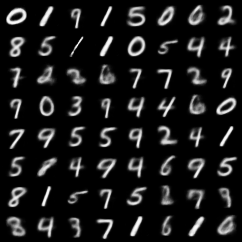

In [ ]:
from PIL import Image

im = Image.open(args.predict_img_vae)
im

# [Conditional VAE](https://github.com/lyeoni/pytorch-mnist-CVAE/tree/master)

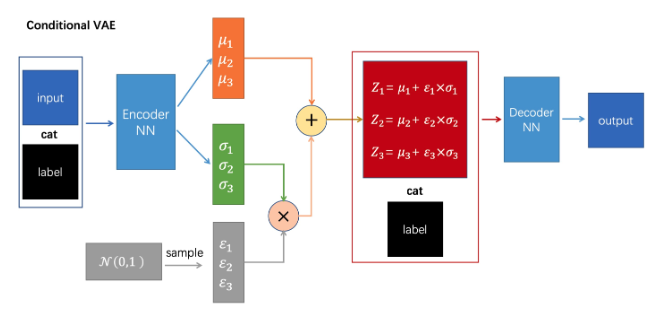

## Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super().__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim + c_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

    def forward(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, c_dim):
        super().__init__()

        # decoder part
        self.fc4 = nn.Linear(z_dim + c_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def forward(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))


In [ ]:
class CVAE(nn.Module):
    def __init__(self, c_dim, x_dim=784, h_dim1=512, h_dim2=256, z_dim=2):
        super().__init__()
        self.c_dim = c_dim

        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim, c_dim)
        # decoder part
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim, c_dim)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

In [ ]:
# build model
cond_dim = train_loader.dataset.train_labels.unique().size(0)
cvae_model = CVAE(c_dim=cond_dim).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
torchinfo.summary(cvae_model,((32, 1, 28, 28), (32,10)), col_names=["kernel_size", "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
CVAE                                     --                        [32, 1, 28, 28]           [32, 784]                 --
├─Encoder: 1-1                           --                        [32, 784]                 [32, 2]                   --
│    └─Linear: 2-1                       --                        [32, 794]                 [32, 512]                 407,040
│    └─Linear: 2-2                       --                        [32, 512]                 [32, 256]                 131,328
│    └─Linear: 2-3                       --                        [32, 256]                 [32, 2]                   514
│    └─Linear: 2-4                       --                        [32, 256]                 [32, 2]                   514
├─Decoder: 1-2                           --                        [32, 2]                   [32, 784]                 --
│    └─

## Engine

In [ ]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss: # 현재 loss가 최고 loss보다 더 낮은 경우
            self.best_loss = loss # 최고 loss를 현재 loss로 업데이트
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path) # 최고 loss를 갖은 모델 저장
            return True
        elif self.trial_counter + 1 < self.num_trials: # 현재 loss가 최고 loss보다 작은 경우 & max 시도횟수보다 현재 시도횟수가 작은 경우
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else: # 현재 정확도가 최고 정확도보다 작은 경우 & 현재 시도횟수가 max 시도횟수보다 큰 경우
            return False

    def get_best_model(self, device):
        return torch.load(self.save_path).to(device)

In [ ]:
def train(epoch, model, dataloader, loss_fn, one_hot_fn, optimizer, device):
    model.train()

    train_loss = 0

    for batch_idx, (data, cond) in enumerate(dataloader):
        data = data.to(device)
        cond = one_hot_fn(cond, model.c_dim).to(device)

        recon_batch, mu, log_var = model(data, cond)
        loss = loss_fn(recon_batch, data, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss

In [ ]:
def test(model, dataloader, loss_fn, one_hot_fn, device):
    model.eval()

    test_loss= 0

    with torch.inference_mode():
        for data, cond in dataloader:
            data = data.to(device)
            cond = one_hot_fn(cond, model.c_dim).to(device)

            recon_batch, mu, log_var = model(data, cond)
            loss = loss_fn(recon_batch, data, mu, log_var)

            # sum up batch loss
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss

## Training

In [ ]:
cvae_model = CVAE(c_dim=cond_dim).to(device)

In [ ]:
optimizer = optim.Adam(cvae_model.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# one-hot encoding
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [ ]:
early_stopper = EarlyStopper(num_trials=args.NUM_TRIALS, save_path=args.best_cvae_model)

In [ ]:
for epoch in range(1, args.NUM_EPOCHS):
    # training
    train(epoch, cvae_model, train_loader, loss_function, one_hot, optimizer, device)
    # testing
    test_loss = test(cvae_model, test_loader, loss_function, one_hot, device)

    # early stopper
    if not early_stopper.is_continuable(cvae_model, test_loss):
        print(f'validation: best loss: {early_stopper.best_loss}')
        break

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.759922
Train Epoch: 1 [10000/60000 (17%)]	Loss: 181.316758
Train Epoch: 1 [20000/60000 (33%)]	Loss: 157.436660
Train Epoch: 1 [30000/60000 (50%)]	Loss: 151.952070
Train Epoch: 1 [40000/60000 (67%)]	Loss: 146.725557
Train Epoch: 1 [50000/60000 (83%)]	Loss: 140.590664
====> Epoch: 1 Average loss: 163.8734
====> Test set loss: 141.3565
Train Epoch: 2 [0/60000 (0%)]	Loss: 154.304053
Train Epoch: 2 [10000/60000 (17%)]	Loss: 139.377969
Train Epoch: 2 [20000/60000 (33%)]	Loss: 137.827275
Train Epoch: 2 [30000/60000 (50%)]	Loss: 144.684482
Train Epoch: 2 [40000/60000 (67%)]	Loss: 142.573291
Train Epoch: 2 [50000/60000 (83%)]	Loss: 136.872637
====> Epoch: 2 Average loss: 138.7616
====> Test set loss: 136.2443
Train Epoch: 3 [0/60000 (0%)]	Loss: 138.622627
Train Epoch: 3 [10000/60000 (17%)]	Loss: 134.429307
Train Epoch: 3 [20000/60000 (33%)]	Loss: 136.093037
Train Epoch: 3 [30000/60000 (50%)]	Loss: 130.232910
Train Epoch: 3 [40000/60000 (67%)]	Loss: 140.78

## Prediction

In [ ]:
best_model = early_stopper.get_best_model(device)

In [ ]:
with torch.no_grad():
    z = torch.randn(10, 2).to(device)
    c = torch.eye(10).to(device)

    sample = best_model.decoder(z, c)
    save_image(sample.view(10, 1, 28, 28), args.predict_img_cvae)

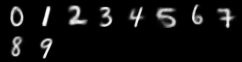

In [ ]:
from PIL import Image

im = Image.open(args.predict_img_cvae)
im